# XGBoost feature selection

## Summary (plain English)

### Aim

The aim is to identify the most important features that are predictive of patient outcome, and to select those features we will use in a simplified model from this point on wards.

### Methods

We measure accuracy (as 'ROC-AUC') across five train/test data splits. We pick one feature ata time that most increases accuracy and select that feature for all further model fits.

### Results

The ROC-AUC with all data was 0.816. A model with 7 features could achieve an ROC-AUC of 0.815. These features (in order of importance) were:

1. Prior disability
2. Stroke severity
3. Stroke Team
4. Age
5. Year
6. Level of consciousness on arrival
7. Scan to thrombolysis time (this was set to 9999 minutes for those who did not receive thrombolysis)

Of these 7 features we chose not to use two of the features:

1. Year, as we are looking to find general patterns across years
2. Level of consciousness on arrival, as this is part of the stroke severity score, and so confounds the effect of stroke severity.

### Conclusions

Five features will be used in all further outcome modelling:

1. Prior disability
2. Stroke severity
3. Stroke Team
4. Age
5. Scan to thrombolysis time (this was set to 9999 minutes for those who did not receive thrombolysis)

## Import libraries

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import scipy

from xgboost import XGBClassifier
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

import json

from dataclasses import dataclass

from sklearn.metrics import confusion_matrix

import seaborn as sns

from sklearn.metrics import roc_auc_score

import time

Report the time duration to run notebook

In [2]:
start_time = time.time()

## Set up paths and filenames

In [3]:
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data.'''

    data_save_path: str = './output/'
    data_read_path: str = '../data/kfold_5fold'
    notebook: str = '01_'

paths = Paths()

## Import data

Data has previously been split into 5 stratified k-fold splits.

In [4]:
train_data, test_data = [], []

for i in range(5):
    
    train_data.append(pd.read_csv(paths.data_read_path + '/03_train_{0}.csv'.format(i)))
    test_data.append(pd.read_csv(paths.data_read_path + '/03_test_{0}.csv'.format(i)))

Get list of features

In [5]:
features = list(train_data[0])
print(f"There are {len(features)} features")

There are 51 features


## One hot code the categorical features

Convert some categorical features to one hot encoded features.

Define a function

In [6]:
def convert_feature_to_one_hot(df, feature_name, prefix):
    """
    df [dataframe]: training or test dataset
    feature_name [str]: feature to convert to ont hot encoding
    prefix [str]: string to use on new feature
    """

    # One hot encode a feature
    df_feature = pd.get_dummies(
        df[feature_name], prefix = prefix)
    df = pd.concat([df, df_feature], axis=1)
    df.drop(feature_name, axis=1, inplace=True)

    return(df)

Set up two lists for the one hot encoding. 

A list of the feature names that are categorical and to be converted using one hot encoding.
A list of the prefixes to use for these features.

In [7]:
features_to_one_hot = ["stroke_team", "weekday"]
list_prefix = ["team", "weekday"]

## Fit XGBoost model

Train model with all features (as comparison)

In [8]:
r_square_kfold = []
roc_auc_ovr_kfold = []

# Loop through k folds
for k_fold in range(5):

    # Get k fold split
    train = train_data[k_fold]
    test = test_data[k_fold]

    # Get X and y
    X_train = train.drop('discharge_disability', axis=1)
    X_test = test.drop('discharge_disability', axis=1)
    y_train = train['discharge_disability']
    y_test = test['discharge_disability']

    # One hot encode categorical features
    for feature, prefix in zip(features_to_one_hot, list_prefix):
        X_train = convert_feature_to_one_hot(X_train, feature, prefix)
        X_test = convert_feature_to_one_hot(X_test, feature, prefix)

    # Define model
    model = XGBClassifier(
        verbosity=0, seed=42, learning_rate=0.5, tree_method='gpu_hist')

    # Fit model
    model.fit(X_train, y_train)

    # Get target categories from model
    classes = model.classes_

    # Get predicted probabilities
    y_probs = model.predict_proba(X_test)

    # Calculate ROC AUC for multiclass models, using One vs Rest
    roc_auc_ovr = roc_auc_score(y_test, y_probs, labels = classes, 
                                multi_class = 'ovr', average = 'macro')
    roc_auc_ovr_kfold.append(roc_auc_ovr)

# Get average result from all k-fold splits
roc_auc_ovr_mean = np.mean(roc_auc_ovr_kfold)

print (f'All features, AUC: {roc_auc_ovr_mean:0.3f} '
       f'(std across 5 kfolds: {np.std(roc_auc_ovr_mean):0.3f})')

All features, AUC: 0.816 (std across 5 kfolds: 0.000)


Check that the five ROC AUC are not identical (to give the stddev 0)

In [9]:
roc_auc_ovr_kfold

[0.8157738557532797,
 0.8166220153277053,
 0.8184124266961358,
 0.8170253492373047,
 0.8137555945131912]

## Fit XGBoost model

Loop through each feature in turn and train an XGBoost model with that feature added to the dataset (for each k-fold split). Choose the single best feature to add to the model in terms of performance from the ROC AUC using one vs rest (mean of the k-fold splits).

Repeat until 25 features have been selected.

In [10]:
# Create list to store accuracies and chosen features
roc_auc_by_feature_number = []
roc_auc_by_feature_number_kfold = []
chosen_features = []

# Initialise chosen features list and run tracker
available_features = list(train_data[0].drop('discharge_disability', axis=1))
number_of_features = len(available_features)

# Loop through number of features
for i in range (25):
    
    # Reset best feature and accuracy
    best_result = 0
    best_feature = ''
    
    # Loop through available features
    for feature in available_features:

        # Create copy of already chosen features to avoid original being changed
        features_to_use = chosen_features.copy()
        # Create a list of features from features already chosen + 1 new feature
        features_to_use.append(feature)
        
        # Set up a list to hold AUC results for this feature for each kfold
        feature_roc_auc_ovr_kfold = []
        
        # Loop through k folds
        for k_fold in range(5):

            # Get k fold split
            train = train_data[k_fold]
            test = test_data[k_fold]

            # Get X and y
            X_train = train.drop('discharge_disability', axis=1)
            X_test = test.drop('discharge_disability', axis=1)
            y_train = train['discharge_disability']
            y_test = test['discharge_disability']
            
            # Restrict features
            X_train = X_train[features_to_use]
            X_test = X_test[features_to_use]

            # One hot encode categorical features
            for cat_feature, prefix in zip(features_to_one_hot, list_prefix):
                if cat_feature in features_to_use:
                    X_train = convert_feature_to_one_hot(X_train, cat_feature, prefix)
                    X_test = convert_feature_to_one_hot(X_test, cat_feature, prefix)

            # Define model
            model = XGBClassifier(
                verbosity=0, seed=42, learning_rate=0.5, tree_method='gpu_hist')

            # Fit model
            model.fit(X_train, y_train)

            # Get predicted probabilities
            y_probs = model.predict_proba(X_test)
            
            # Calculate ROC AUC for multiclass models, using One vs Rest
            feature_roc_auc_ovr = roc_auc_score(y_test, y_probs, labels = classes, 
                                multi_class = 'ovr', average = 'macro')
            feature_roc_auc_ovr_kfold.append(feature_roc_auc_ovr)
        
        # Get average result from all k-fold splits
        feature_auc_mean = np.mean(feature_roc_auc_ovr_kfold)
    
        # Update chosen feature and result if this feature is a new best
        if feature_auc_mean > best_result:
            best_result = feature_auc_mean
            best_result_kfold = feature_roc_auc_ovr_kfold
            best_feature = feature
            
    # k-fold splits are complete    
    # Add mean accuracy and AUC to record of accuracy by feature number
    roc_auc_by_feature_number.append(best_result)
    roc_auc_by_feature_number_kfold.append(best_result_kfold)
    chosen_features.append(best_feature)
    available_features.remove(best_feature)
            
    print (f'Feature {i+1:2.0f}: {best_feature}, AUC: {best_result:0.3f}')

Feature  1: prior_disability, AUC: 0.687
Feature  2: stroke_severity, AUC: 0.770
Feature  3: stroke_team, AUC: 0.800
Feature  4: age, AUC: 0.805
Feature  5: year, AUC: 0.811
Feature  6: nihss_arrival_loc, AUC: 0.813
Feature  7: scan_to_thrombolysis_time, AUC: 0.815
Feature  8: nihss_arrival_best_language, AUC: 0.816
Feature  9: thrombolysis_no_but_improving, AUC: 0.817
Feature 10: nihss_arrival_loc_questions, AUC: 0.817
Feature 11: nihss_arrival_sensory, AUC: 0.817
Feature 12: nihss_arrival_motor_arm_left, AUC: 0.818
Feature 13: id, AUC: 0.818
Feature 14: thrombolysis_no_but_other_medical, AUC: 0.818
Feature 15: infarction, AUC: 0.818
Feature 16: arrive_by_ambulance, AUC: 0.818
Feature 17: onset_during_sleep, AUC: 0.818
Feature 18: nihss_arrival_dysarthria, AUC: 0.818
Feature 19: male, AUC: 0.818
Feature 20: nihss_arrival_motor_arm_right, AUC: 0.818
Feature 21: afib_anticoagulant, AUC: 0.818
Feature 22: congestive_heart_failure, AUC: 0.818
Feature 23: nihss_arrival_facial_palsy, AUC: 0

Create a dataframe that contains the chosen features, and their mean ROC AUC across the k-fold splits, and the standard deviation.

In [11]:
results = pd.DataFrame()
results['number_features'] = range(1, len(chosen_features)+1)
results['feature'] = chosen_features
results['AUC'] = roc_auc_by_feature_number
results

,number_features,feature,AUC
0,1,prior_disability,0.687344
1,2,stroke_severity,0.770262
2,3,stroke_team,0.799953
3,4,age,0.805349
4,5,year,0.810668
5,6,nihss_arrival_loc,0.813225
6,7,scan_to_thrombolysis_time,0.814874
7,8,nihss_arrival_best_language,0.815812
8,9,thrombolysis_no_but_improving,0.816838
9,10,nihss_arrival_loc_questions,0.817141


In [12]:
results.to_csv(f'{paths.data_save_path}/{paths.notebook}feature_selection.csv', index=False)

## Plot the results
Plot a line graph showing the change in mean ROC AUC (across k-fold splits) for the number of features chosen in the model.

In [13]:
results = pd.read_csv(f'{paths.data_save_path}/{paths.notebook}feature_selection.csv')

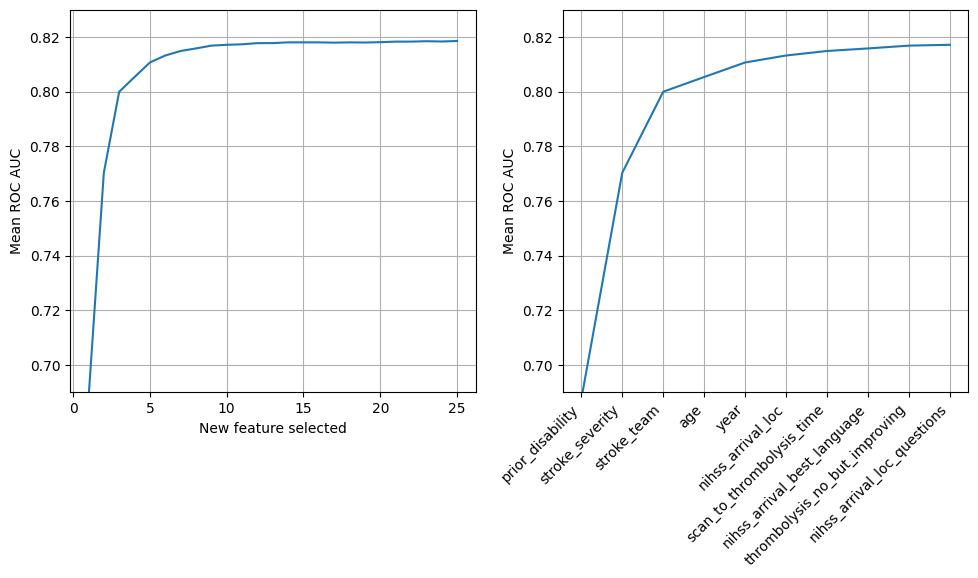

In [14]:
features_to_show = 10

fig = plt.figure(figsize=(10,6))

ax1 = fig.add_subplot(121)
ax1.plot(results['number_features'], results['AUC'])
ax1.set_xlabel('Number of features')
ax1.set_ylabel('Mean ROC AUC')
ax1.set_ylim(0.69, 0.83)
ax1.grid()

ax2 = fig.add_subplot(122)
ax2.plot(results['feature'][:features_to_show],
         results['AUC'][:features_to_show])
xlabels = list(results['feature'])
xlabels = xlabels[:features_to_show]
ax2.set_xticklabels(xlabels, rotation=45, ha='right')
ax2.set_ylabel('Mean ROC AUC')
ax1.set_xlabel('New feature selected')
ax2.set_ylim(0.69, 0.83)
ax2.grid()

plt.tight_layout(pad=1.5)

plt.savefig(f'{paths.data_save_path}/{paths.notebook}feature_selection.jpg', dpi=300)
plt.show()

Save dictionary as a json (to be read in and used by the other notebooks).

In [15]:
feature_name_dict = {
    "prior_disability": "Prior disability level",
    "stroke_severity": "Stroke severity",
    "stroke_team": "Stroke team",
    "age": "Age",
    "year": "Year",
    "nihss_arrival_loc": "NIHSS arrival LOC",
    "scan_to_thrombolysis_time": "Scan-to-thrombolysis time",
    "thrombolysis_no_but_improving": "Thrombolysis-No but improving",
    "nihss_arrival_motor_arm_left": "NIHSS arrival motor arm left",
    "nihss_arrival_best_gaze": "NIHSS arrival best gaze",
    "nihss_arrival_motor_arm_right": "NIHSS arrival motor arm right",
    "male": "Male",
    "month": "Month",
    "nihss_arrival_dysarthria": "NIHSS arrival dysarthria",
    "infarction": "Infarction",
    "arrive_by_ambulance": "Arrive by ambulance",
    "thrombolysis_no_but_too_mild_severe": "Thrombolysis-No but too mild severe",
    "diabetes": "Diabetes",
    "thrombolysis_no_but_haemorrhagic": "Thrombolysis-No but haemorrhagic",
    "nihss_arrival_motor_leg_right": "NIHSS arrival motor leg right",
    "nihss_arrival_sensory": "NIHSS arrival sensory",
    "afib_antiplatelet": "AFIB antiplatelet",
    "afib_anticoagulant": "AFIB_anticoagulant",
    "thrombolysis_no_but_other_medical": "Thrombolysis-No but other medical",
    "nihss_arrival_best_language": "NIHSS arrival best language",
    "congestive_heart_failure": "Congestive heart failure",
    "nihss_arrival_limb_ataxia": "NIHSS arrival limb ataxia",
    "nihss_arrival_loc_questions": "NIHSS arrival LOC questions"
}

In [16]:
with open(f'{paths.data_save_path}/{paths.notebook}feature_name_dict.json', "w+") as f:
    json.dump(feature_name_dict, f)

In [17]:
end_time = time.time()

print(f'Time taken: {end_time - start_time}')

Time taken: 22144.506618499756
